In [ ]:
!kaggle datasets list

In [ ]:
!kaggle datasets list -s flowers

In [ ]:
# Download the dataset
!kaggle datasets download -d alxmamaev/flowers-recognition

In [ ]:
# Unzip the dataset
!tar -xf flowers-recognition.zip

In [ ]:
# Import modules
import os
from PIL import Image
import random
import matplotlib.pyplot as plt 
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision.io import read_image, ImageReadMode
import random
import numpy as np

Number of images of  daisy : 764
Number of images of  dandelion : 1052
Number of images of  rose : 784
Number of images of  sunflower : 733
Number of images of  tulip : 984


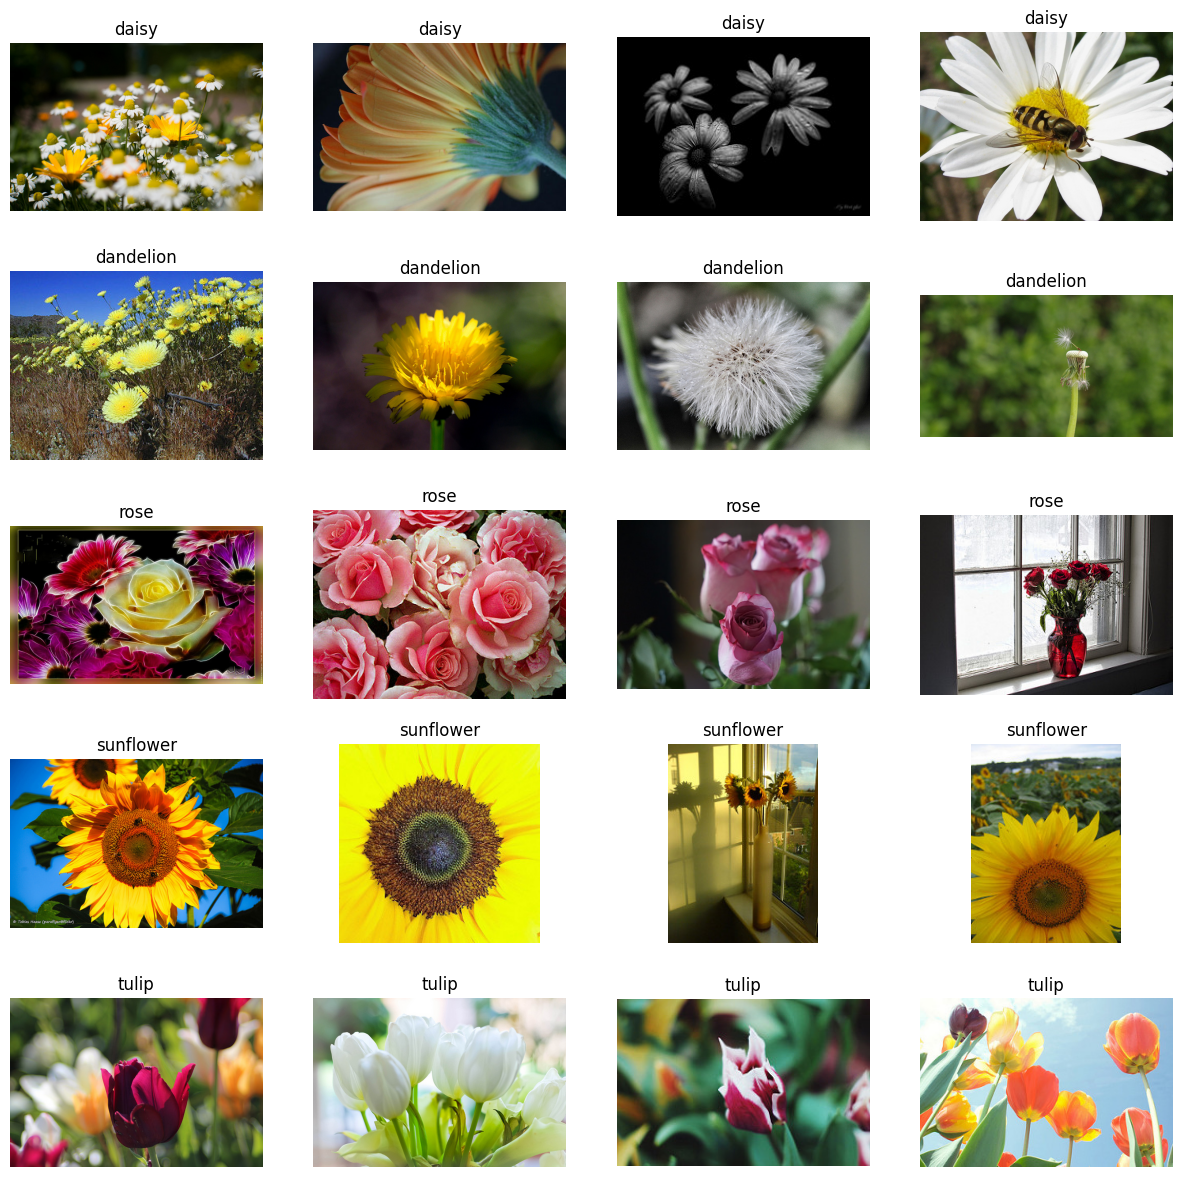

In [2]:
# Explore the data
fig = plt.figure(figsize=(15,15)) 
tot_images = 20
num_images_for_each = 4
for num_folder, folder in enumerate(os.listdir("flowers")):
    print("Number of images of ", folder,":",len(os.listdir("flowers/" + folder)))
    files = os.listdir("flowers/" + folder)
    random.shuffle(files)
    for num, fn in enumerate(files[:num_images_for_each]):
        path = os.path.join("flowers/" + folder,fn)
        img = Image.open(path)
        plt.subplot(tot_images//4,4,num_folder*4+num+1)
        plt.title(folder)
        plt.axis('off')
        plt.imshow(img)
plt.show()

Let's try our first attempt with the Plain-CNN that we defined last time! 

In [ ]:
from .Lab_1.

# Test the network 
model = PlainCNN([1,2,2,2,2], 5)
model.test_forward(torch.randn(1,3,224,224))

In [ ]:
# Define the transformations that we want to apply in training and inference 

import torchvision.transforms as transf
from dataset import split_dataset

transforms_train = transf.Compose([transf.Resize((224,224)), 
                            transf.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
transforms_test_val = transf.Compose([transf.Resize((224,224)), 
                            transf.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

train_images, val_images, test_images = split_dataset("flowers", train_proportion=0.8, val_proportion=0.1)

In [ ]:
from torch.optim import SGD
from torch.nn import CrossEntropyLoss
from tqdm import tqdm
from dataset import get_train_val_loaders, FlowerDataset

if __name__ == "__main__":

  trainset = FlowerDataset(train_images, transforms_train)
  valset = FlowerDataset(val_images, transforms_test_val)

  trainloader, valloader = get_train_val_loaders(trainset, valset, batch_size=8)

  # Use cuda if available
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  # Get the model 
  model = PlainCNN([1,4,4,4,4], n_classes=5)
  model.to(device)

  print("Tot model parameters:", sum([param.numel() for param in model.parameters()]))
  print("Trainable model parameters:", sum([param.numel() for param in model.parameters() if param.requires_grad]))

  # Hyperparameters 
  learning_rate = 5e-3
  epochs = 20

  # Get the optimizer
  optimizer = SGD(model.parameters(),lr=learning_rate, weight_decay=1e-4, momentum=0.9)

  # Get the loss function 
  loss_fn = CrossEntropyLoss(reduction="mean")

  # Start the training loop
  for epoch in range(epochs):
    loss_training = 0
    accuracy_training = 0 
    print("Epoch:", epoch)
    for i, data in enumerate(tqdm(trainloader)):
      imgs, labels = data
      # Send data to GPU
      imgs = imgs.to(device)
      labels = labels.to(device)
      predictions = model(imgs)
      loss = loss_fn(predictions,labels.view(-1))
      
      # Calculate the training accuracy 
      accuracy_training += (sum(predictions.argmax(1)==labels)/imgs.shape[0]).item()

      # Zero the gradients in the optimizer
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      loss_training += loss.item()
    
    # Test on validation images 
    loss_validation = 0
    accuracy_validation = 0
    with torch.no_grad():
      model.eval()
      for i, data in enumerate(tqdm(valloader)):
        imgs, labels = data
        # Send data to GPU
        imgs = imgs.to(device)
        labels = labels.to(device)
        
        predictions = model(imgs)
        loss = loss_fn(predictions,labels.view(-1))
        loss_validation += loss.item()
        accuracy_validation += (sum(predictions.argmax(1)==labels)/imgs.shape[0]).item()
        
      # Put again model in training mode
      model.train()

    print("\nTraining loss epoch ",epoch,":",loss_training/len(trainloader))
    print("Training accuracy epoch ",epoch,":",accuracy_training/len(trainloader))
    print("Validation loss epoch ",epoch,":",loss_validation/len(valloader))
    print("Validation accuracy epoch ",epoch,":",accuracy_validation/len(valloader))

In [ ]:
# Save the weights of the network
torch.save(model.state_dict(), "weights/weights_plain_18.pth")

In [ ]:
# Load the weights of the network 
model = PlainCNN([1,4,4,4,4], n_classes=5)
model.load_state_dict(torch.load("weights/weights_plain_18.pth"))

In [ ]:
# Let's try to predict some test images and the predictions

from dataset import FlowerDataset
from dataset import get_test_loader

fig = plt.figure(figsize=(15,15))
num_images = 16
testset = FlowerDataset(test_images, None)
testloader = get_test_loader(testset, batch_size=1)
testloader = iter(testloader)

model.eval()
with torch.no_grad():
  for i in range(num_images):
    image, label = next(testloader)
    # Apply transformation on image
    image_transf = transforms_test_val(image)
    out = model(image_transf)
    prediction = out.argmax(1)
    plt.subplot(num_images//4,4,i+1)
    plt.axis('off')
    plt.imshow(image.squeeze().moveaxis(0,-1))
    if(prediction.item()==0):
      plt.title("This is a daisy!\n")
    elif (prediction.item()==1):
      plt.title("This is a dandelion!\n")
    elif (prediction.item()==2):
      plt.title("This is a rose!\n")
    elif (prediction.item()==3):
      plt.title("This is a sunflower!\n")
    elif(prediction.item()==4):
      plt.title("This is a tulip!\n")

plt.show()

In [ ]:
# Let's calculate the accuracy on the test set 
testset = FlowerDataset(test_images, transforms_test_val)
testloader = get_test_loader(testset, batch_size=8)
loss_fn = CrossEntropyLoss(reduction="mean")
# Put the model in evaluation mode
model.eval()
# Send the model to the device
model.to(device)
with torch.no_grad():
    loss_test = 0 
    accuracy_test = 0
    for i, data in enumerate(tqdm(testloader)):
        imgs, labels = data 
        # Send data to device
        imgs = imgs.to(device)
        labels = labels.to(device)
        # Predict
        predictions = model(imgs)
        loss = loss_fn(predictions,labels)
        loss_test += loss.item()
        accuracy_test += (sum(predictions.argmax(1)==labels)/imgs.shape[0]).item()
        
print("\nTest loss:",loss_test/len(testloader))
print("Test accuracy:",accuracy_test/len(testloader))

Do it with a residual connections network!

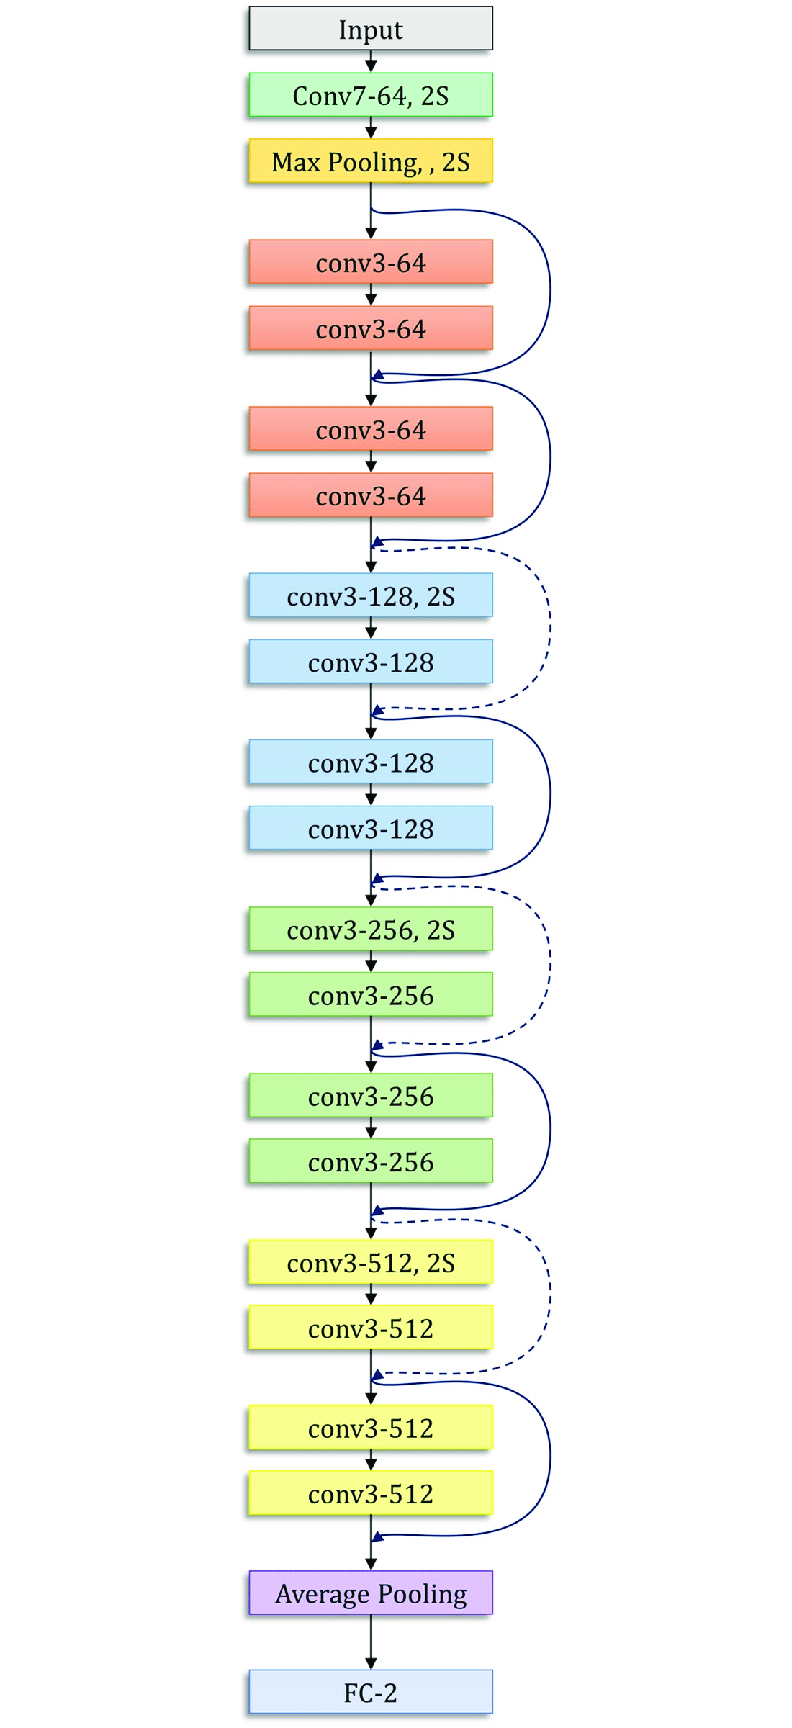

In [ ]:
class SkipLayer(nn.Module):
    '''
    Implements a single skip connection sub-block of the residual CNN. It consists of two convolutional layers with batch normalization and ReLU activation.
    '''
    def __init__(self, in_ch, out_ch, kernel_size, stride_first_conv=1):
        super(SkipLayer, self).__init__()
        layers = []
        self.stride_first_conv = stride_first_conv
        if(stride_first_conv!=1):
            self.conv1x1 = nn.Conv2d(in_ch, in_ch*2, 1, stride=stride_first_conv, bias=False)
            self.bn = nn.BatchNorm2d(in_ch*2)
        # Append first convolutional layer
        layers.append(nn.Conv2d(in_ch, out_ch, kernel_size, stride=stride_first_conv, padding=1, bias=False))
        layers.append(nn.BatchNorm2d(out_ch))
        layers.append(nn.ReLU(inplace=True))
        # Append second convolutional layer
        layers.append(nn.Conv2d(out_ch, out_ch, kernel_size, stride=1, padding=1, bias=False))
        layers.append(nn.BatchNorm2d(out_ch))
        self.layers = nn.Sequential(*layers)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x 
        out = self.layers(x)

        if self.stride_first_conv!=1:
            # Project the identity to match the correct dimension
            identity = self.bn(self.conv1x1(identity))

        return self.relu(out + identity)

class SkipBlock(nn.Module):
    '''
    Implements one block of the residual CNN described in the paper "Deep residual learning for image recognition" by He et al. (2015)
    Here block refers to the different coloured parts of the network in the figure of the paper.
    '''
    def __init__(self, in_ch, out_ch, kernel_size, num_layers, first_layer_stride=2):
        super(SkipBlock, self).__init__()
        layers = []

        # Append the skip connections
        for i in range(num_layers):
            if i == 0:
                layers.append(SkipLayer(in_ch, out_ch, kernel_size, stride_first_conv=first_layer_stride))
            else:
                layers.append(SkipLayer(out_ch, out_ch, kernel_size, stride_first_conv=1))
        
        self.layers = nn.Sequential(*layers)

    
    def forward(self, x):
        return self.layers(x)

class SkipCNN(nn.Module):
    def __init__(self, config, n_classes=5):
        super(SkipCNN, self).__init__()
        self.config = config

        self.pool = nn.MaxPool2d(2, 2)
        self.block1 = PlainBlock(3, 64, 7, config[0], first_layer_stride=2, padding=3)
        self.block2 = SkipBlock(64, 64, 3, config[1], first_layer_stride=1)
        self.block3 = SkipBlock(64, 128, 3, config[2], first_layer_stride=2)
        self.block4 = SkipBlock(128, 256, 3, config[3], first_layer_stride=2)
        self.block5 = SkipBlock(256, 512, 3, config[4], first_layer_stride=2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, n_classes)

    
    def forward(self, x):
        x = self.block1(x)
        x = self.pool(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)

        x = self.avg_pool(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        return x
    
    def test_forward(self, x):
        x = self.block1(x)
        print("First block")
        print(x.shape)
        x = self.pool(x)
        print("Pool")
        print(x.shape)
        x = self.block2(x)
        print("Second block")
        print(x.shape)
        x = self.block3(x)
        print("Third block")
        print(x.shape)
        x = self.block4(x)
        print("Fourth block")
        print(x.shape)
        x = self.block5(x)
        print("Fifth block")
        print(x.shape)
        x = self.avg_pool(x)
        print(x.shape)
        x = torch.flatten(x, start_dim=1)
        print(x.shape)
        x = self.fc(x)
        print(x.shape)

In [ ]:
# Let's see if the number of parameters is the same as the resnet18 from pytorch!

from torchvision.models import resnet18

network1 = resnet18()
network1.fc = nn.Linear(512,5)

print("Parameters of the ResNet18 model:", sum([param.numel() for param in network1.parameters()]))

network = SkipCNN([1,2,2,2,2])

print("Parameters of the SkipCNN model:", sum([param.numel() for param in network.parameters()]))

del network1
del network

In [ ]:
from torch.optim import SGD
from torch.nn import CrossEntropyLoss
from tqdm import tqdm
from dataset import get_train_val_loaders, FlowerDataset

if __name__ == "__main__":

  trainset = FlowerDataset(train_images, transforms_train)
  valset = FlowerDataset(val_images, transforms_test_val)

  trainloader, valloader = get_train_val_loaders(trainset, valset, batch_size=8)

  # Use cuda if available
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  # Get the model 
  model = SkipCNN([1,2,2,2,2], n_classes=5)
  model.to(device)

  print("Tot model parameters:", sum([param.numel() for param in model.parameters()]))

  # Hyperparameters 
  learning_rate = 5e-3
  epochs = 20

  # Get the optimizer
  optimizer = SGD(model.parameters(),lr=learning_rate, weight_decay=1e-4, momentum=0.9)

  # Get the loss function 
  loss_fn = CrossEntropyLoss(reduction="mean")

  # Start the training loop
  for epoch in range(epochs):
    loss_training = 0
    accuracy_training = 0 
    print("Epoch:", epoch)
    for i, data in enumerate(tqdm(trainloader)):
      imgs, labels = data
      # Send data to GPU
      imgs = imgs.to(device)
      labels = labels.to(device)
      predictions = model(imgs)
      loss = loss_fn(predictions,labels.view(-1))
      
      # Calculate the training accuracy 
      accuracy_training += (sum(predictions.argmax(1)==labels)/imgs.shape[0]).item()

      # Zero the gradients in the optimizer
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      loss_training += loss.item()
    
    # Test on validation images 
    loss_validation = 0
    accuracy_validation = 0
    with torch.no_grad():
      model.eval()
      for i, data in enumerate(tqdm(valloader)):
        imgs, labels = data
        # Send data to GPU
        imgs = imgs.to(device)
        labels = labels.to(device)
        
        predictions = model(imgs)
        loss = loss_fn(predictions,labels.view(-1))
        loss_validation += loss.item()
        accuracy_validation += (sum(predictions.argmax(1)==labels)/imgs.shape[0]).item()
        
      # Put again model in training mode
      model.train()

    print("\nTraining loss epoch ",epoch,":",loss_training/len(trainloader))
    print("Training accuracy epoch ",epoch,":",accuracy_training/len(trainloader))
    print("Validation loss epoch ",epoch,":",loss_validation/len(valloader))
    print("Validation accuracy epoch ",epoch,":",accuracy_validation/len(valloader))

In [ ]:
# Save the weights of the network
torch.save(model.state_dict(), "weights/weights_skip_18.pth")

In [ ]:
# Load the weights of the network 
model = SkipCNN([1,2,2,2,2], n_classes=5)
model.load_state_dict(torch.load("weights/weights_skip_18.pth"))

In [ ]:
# Explore the data 
from dataset import FlowerDataset
from dataset import get_test_loader

fig = plt.figure(figsize=(15,15))
num_images = 16
testset = FlowerDataset(test_images, None)
testloader = get_test_loader(testset, batch_size=1)
testloader = iter(testloader)

model.eval()
with torch.no_grad():
  for i in range(num_images):
    image, label = next(testloader)
    # Apply transformation on image
    image_transf = transforms_test_val(image)
    out = model(image_transf)
    prediction = out.argmax(1)
    plt.subplot(num_images//4,4,i+1)
    plt.axis('off')
    plt.imshow(image.squeeze().moveaxis(0,-1))
    if(prediction.item()==0):
      plt.title("This is a daisy!\n")
    elif (prediction.item()==1):
      plt.title("This is a dandelion!\n")
    elif (prediction.item()==2):
      plt.title("This is a rose!\n")
    elif (prediction.item()==3):
      plt.title("This is a sunflower!\n")
    elif(prediction.item()==4):
      plt.title("This is a tulip!\n")

plt.show()

In [ ]:
# Let's calculate the accuracy on the test set 
testset = FlowerDataset(test_images, transforms_test_val)
testloader = get_test_loader(testset, batch_size=8)
loss_fn = CrossEntropyLoss(reduction="mean")
# Put the model in evaluation mode
model.eval()
# Send the model to the device
model.to(device)
with torch.no_grad():
    loss_test = 0 
    accuracy_test = 0
    for i, data in enumerate(tqdm(testloader)):
        imgs, labels = data 
        # Send data to device
        imgs = imgs.to(device)
        labels = labels.to(device)
        # Predict
        predictions = model(imgs)
        loss = loss_fn(predictions,labels)
        loss_test += loss.item()
        accuracy_test += (sum(predictions.argmax(1)==labels)/imgs.shape[0]).item()
        
print("\nTest loss:",loss_test/len(testloader))
print("Test accuracy:",accuracy_test/len(testloader))

# Do it with transfer learning 

In [ ]:
# Build datasets, dataloader
import torchvision.transforms as transf

transforms_train = transf.Compose([
                            transf.Resize((224,224)),
                            transf.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
transforms_test_val = transf.Compose([
                            transf.Resize((224,224)),
                            transf.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [ ]:
from torch.optim import SGD
from torch.nn import CrossEntropyLoss
from tqdm import tqdm
from dataset import get_train_val_loaders, FlowerDataset
from torchvision.models import resnet18, ResNet18_Weights

if __name__ == "__main__":

  trainset = FlowerDataset(train_images, transforms_train)
  valset = FlowerDataset(val_images, transforms_test_val)

  trainloader, valloader = get_train_val_loaders(trainset, valset, batch_size=8)

  # Use cuda if available
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  # Get the model 
  model = resnet18(weights=ResNet18_Weights.DEFAULT)
  # Modify the last classification layer 
  model.fc = nn.Linear(512,5)
  # Freeze all except the last layer
  for name, param in model.named_parameters():
    if "fc" not in name:
      param.requires_grad = False
    
  model.to(device)

  print("Tot model parameters:", sum([param.numel() for param in model.parameters()]))
  print("Trainable parameters:", sum([param.numel() for param in model.parameters() if param.requires_grad]))

  # Hyperparameters 
  learning_rate = 1e-3
  epochs = 10

  # Get the optimizer
  optimizer = SGD(model.parameters(),lr=learning_rate, weight_decay=1e-6, momentum=0.9)

  # Get the loss function 
  loss_fn = CrossEntropyLoss(reduction="mean")

  # Start the training loop
  for epoch in range(epochs):
    loss_training = 0
    accuracy_training = 0 
    print("Epoch:", epoch)
    for i, data in enumerate(tqdm(trainloader)):
      imgs, labels = data
      # Send data to GPU
      imgs = imgs.to(device)
      labels = labels.to(device)
      predictions = model(imgs)
      loss = loss_fn(predictions,labels.view(-1))
      
      # Calculate the training accuracy 
      accuracy_training += (sum(predictions.argmax(1)==labels)/imgs.shape[0]).item()

      # Zero the gradients in the optimizer
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      loss_training += loss.item()
    
    # Test on validation images 
    loss_validation = 0
    accuracy_validation = 0
    with torch.no_grad():
      model.eval()
      for i, data in enumerate(tqdm(valloader)):
        imgs, labels = data
        # Send data to GPU
        imgs = imgs.to(device)
        labels = labels.to(device)
        
        predictions = model(imgs)
        loss = loss_fn(predictions,labels.view(-1))
        loss_validation += loss.item()
        accuracy_validation += (sum(predictions.argmax(1)==labels)/imgs.shape[0]).item()
        
      # Put again model in training mode
      model.train()

    print("\nTraining loss epoch ",epoch,":",loss_training/len(trainloader))
    print("Training accuracy epoch ",epoch,":",accuracy_training/len(trainloader))
    print("Validation loss epoch ",epoch,":",loss_validation/len(valloader))
    print("Validation accuracy epoch ",epoch,":",accuracy_validation/len(valloader))

In [ ]:
# Save the weights of the network
torch.save(model.state_dict(), "weights/weights_resnet_18_linear_probing.pth")

In [ ]:
# Load the weights of the network 
model = resnet18()
model.fc = nn.Linear(512,5)
model.load_state_dict(torch.load("weights/weights_resnet_18_linear_probing.pth"))

In [ ]:
# Explore the data 
from dataset import FlowerDataset
from dataset import get_test_loader

fig = plt.figure(figsize=(15,15))
num_images = 16
testset = FlowerDataset(test_images, None)
testloader = get_test_loader(testset, batch_size=1)
testloader = iter(testloader)

model.eval()
with torch.no_grad():
  for i in range(num_images):
    image, label = next(testloader)
    # Apply transformation on image
    image_transf = transforms_test_val(image)
    out = model(image_transf)
    prediction = out.argmax(1)
    plt.subplot(num_images//4,4,i+1)
    plt.axis('off')
    plt.imshow(image.squeeze().moveaxis(0,-1))
    if(prediction.item()==0):
      plt.title("This is a daisy!\n")
    elif (prediction.item()==1):
      plt.title("This is a dandelion!\n")
    elif (prediction.item()==2):
      plt.title("This is a rose!\n")
    elif (prediction.item()==3):
      plt.title("This is a sunflower!\n")
    elif(prediction.item()==4):
      plt.title("This is a tulip!\n")

plt.show()

In [ ]:
# Let's calculate the accuracy on the test set 
testset = FlowerDataset(test_images, transforms_test_val)
testloader = get_test_loader(testset, batch_size=8)
loss_fn = CrossEntropyLoss(reduction="mean")
# Put the model in evaluation mode
model.eval()
# Send the model to the device
model.to(device)
with torch.no_grad():
    loss_test = 0 
    accuracy_test = 0
    for i, data in enumerate(tqdm(testloader)):
        imgs, labels = data 
        # Send data to device
        imgs = imgs.to(device)
        labels = labels.to(device)
        # Predict
        predictions = model(imgs)
        loss = loss_fn(predictions,labels)
        loss_test += loss.item()
        accuracy_test += (sum(predictions.argmax(1)==labels)/imgs.shape[0]).item()
        
print("\nTest loss:",loss_test/len(testloader))
print("Test accuracy:",accuracy_test/len(testloader))

In [ ]:
from torch.optim import SGD
from torch.nn import CrossEntropyLoss
from tqdm import tqdm
from dataset import get_train_val_loaders, FlowerDataset
from torchvision.models import resnet50, ResNet50_Weights

if __name__ == "__main__":

  trainset = FlowerDataset(train_images, transforms_train)
  valset = FlowerDataset(val_images, transforms_test_val)

  trainloader, valloader = get_train_val_loaders(trainset, valset, batch_size=8)

  # Use cuda if available
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  # Get the model 
  model = resnet50(weights=ResNet50_Weights.DEFAULT)
  # Modify the last classification layer 
  model.fc = nn.Linear(2048,5)
  # Freeze all except the last layer
  for name, param in model.named_parameters():
    if "fc" not in name:
      param.requires_grad = False
    
  model.to(device)

  print("Tot model parameters:", sum([param.numel() for param in model.parameters()]))
  print("Trainable parameters:", sum([param.numel() for param in model.parameters() if param.requires_grad]))

  # Hyperparameters 
  learning_rate = 1e-3
  epochs = 10

  # Get the optimizer
  optimizer = SGD(model.parameters(),lr=learning_rate, weight_decay=1e-6, momentum=0.9)

  # Get the loss function 
  loss_fn = CrossEntropyLoss(reduction="mean")

  # Start the training loop
  for epoch in range(epochs):
    loss_training = 0
    accuracy_training = 0 
    print("Epoch:", epoch)
    for i, data in enumerate(tqdm(trainloader)):
      imgs, labels = data
      # Send data to GPU
      imgs = imgs.to(device)
      labels = labels.to(device)
      predictions = model(imgs)
      loss = loss_fn(predictions,labels.view(-1))
      
      # Calculate the training accuracy 
      accuracy_training += (sum(predictions.argmax(1)==labels)/imgs.shape[0]).item()

      # Zero the gradients in the optimizer
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      loss_training += loss.item()
    
    # Test on validation images 
    loss_validation = 0
    accuracy_validation = 0
    with torch.no_grad():
      model.eval()
      for i, data in enumerate(tqdm(valloader)):
        imgs, labels = data
        # Send data to GPU
        imgs = imgs.to(device)
        labels = labels.to(device)
        
        predictions = model(imgs)
        loss = loss_fn(predictions,labels.view(-1))
        loss_validation += loss.item()
        accuracy_validation += (sum(predictions.argmax(1)==labels)/imgs.shape[0]).item()
        
      # Put again model in training mode
      model.train()

    print("\nTraining loss epoch ",epoch,":",loss_training/len(trainloader))
    print("Training accuracy epoch ",epoch,":",accuracy_training/len(trainloader))
    print("Validation loss epoch ",epoch,":",loss_validation/len(valloader))
    print("Validation accuracy epoch ",epoch,":",accuracy_validation/len(valloader))

In [ ]:
# Save the weights of the network
torch.save(model.state_dict(), "weights/weights_resnet_50_linear_probing.pth")

In [ ]:
from torchvision.models import resnet50
# Load the weights of the network 
model = resnet50()
model.fc = nn.Linear(2048,5)
model.load_state_dict(torch.load("weights/weights_resnet_50_linear_probing.pth"))

In [ ]:
# Explore the data 
from dataset import FlowerDataset
from dataset import get_test_loader

fig = plt.figure(figsize=(15,15))
num_images = 16
testset = FlowerDataset(test_images, None)
testloader = get_test_loader(testset, batch_size=1)
testloader = iter(testloader)

model.eval()
with torch.no_grad():
  for i in range(num_images):
    image, label = next(testloader)
    # Apply transformation on image
    image_transf = transforms_test_val(image)
    out = model(image_transf)
    prediction = out.argmax(1)
    plt.subplot(num_images//4,4,i+1)
    plt.axis('off')
    plt.imshow(image.squeeze().moveaxis(0,-1))
    if(prediction.item()==0):
      plt.title("This is a daisy!\n")
    elif (prediction.item()==1):
      plt.title("This is a dandelion!\n")
    elif (prediction.item()==2):
      plt.title("This is a rose!\n")
    elif (prediction.item()==3):
      plt.title("This is a sunflower!\n")
    elif(prediction.item()==4):
      plt.title("This is a tulip!\n")

plt.show()

In [ ]:
# Let's calculate the accuracy on the test set 
testset = FlowerDataset(test_images, transforms_test_val)
testloader = get_test_loader(testset, batch_size=8)
loss_fn = CrossEntropyLoss(reduction="mean")
# Put the model in evaluation mode
model.eval()
# Send the model to the device
model.to(device)
with torch.no_grad():
    loss_test = 0 
    accuracy_test = 0
    for i, data in enumerate(tqdm(testloader)):
        imgs, labels = data 
        # Send data to device
        imgs = imgs.to(device)
        labels = labels.to(device)
        # Predict
        predictions = model(imgs)
        loss = loss_fn(predictions,labels)
        loss_test += loss.item()
        accuracy_test += (sum(predictions.argmax(1)==labels)/imgs.shape[0]).item()
        
print("\nTest loss:",loss_test/len(testloader))
print("Test accuracy:",accuracy_test/len(testloader))

# Last step, unfreeze all the network and train it again with very little learning rate and weight decay

In [ ]:
from torch.optim import SGD
from torch.nn import CrossEntropyLoss
from tqdm import tqdm
from dataset import get_train_val_loaders, FlowerDataset
from torchvision.models import resnet50

if __name__ == "__main__":

  trainset = FlowerDataset(train_images, transforms_train)
  valset = FlowerDataset(val_images, transforms_test_val)

  trainloader, valloader = get_train_val_loaders(trainset, valset, batch_size=8)

  # Use cuda if available
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

 # Load the weights of the network of the step before
  model = resnet50()
  model.fc = nn.Linear(2048,5)
  model.load_state_dict(torch.load("weights/weights_resnet_50_linear_probing.pth"))
    
  model.to(device)

  print("Tot model parameters:", sum([param.numel() for param in model.parameters()]))
  print("Trainable parameters:", sum([param.numel() for param in model.parameters() if param.requires_grad]))

  # Hyperparameters 
  learning_rate = 1e-5
  epochs = 5

  # Get the optimizer
  optimizer = SGD(model.parameters(),lr=learning_rate, weight_decay=1e-7, momentum=0.9)

  # Get the loss function 
  loss_fn = CrossEntropyLoss(reduction="mean")

  # Start the training loop
  for epoch in range(epochs):
    loss_training = 0
    accuracy_training = 0 
    print("Epoch:", epoch)
    for i, data in enumerate(tqdm(trainloader)):
      imgs, labels = data
      # Send data to GPU
      imgs = imgs.to(device)
      labels = labels.to(device)
      predictions = model(imgs)
      loss = loss_fn(predictions,labels.view(-1))
      
      # Calculate the training accuracy 
      accuracy_training += (sum(predictions.argmax(1)==labels)/imgs.shape[0]).item()

      # Zero the gradients in the optimizer
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      loss_training += loss.item()
    
    # Test on validation images 
    loss_validation = 0
    accuracy_validation = 0
    with torch.no_grad():
      model.eval()
      for i, data in enumerate(tqdm(valloader)):
        imgs, labels = data
        # Send data to GPU
        imgs = imgs.to(device)
        labels = labels.to(device)
        
        predictions = model(imgs)
        loss = loss_fn(predictions,labels.view(-1))
        loss_validation += loss.item()
        accuracy_validation += (sum(predictions.argmax(1)==labels)/imgs.shape[0]).item()
        
      # Put again model in training mode
      model.train()

    print("\nTraining loss epoch ",epoch,":",loss_training/len(trainloader))
    print("Training accuracy epoch ",epoch,":",accuracy_training/len(trainloader))
    print("Validation loss epoch ",epoch,":",loss_validation/len(valloader))
    print("Validation accuracy epoch ",epoch,":",accuracy_validation/len(valloader))

In [ ]:
# Save the weights of the network
torch.save(model.state_dict(), "weights/weights_resnet_50_finetuning.pth")

In [ ]:
# Load the weights of the network 
model = resnet50()
model.fc = nn.Linear(2048,5)
model.load_state_dict(torch.load("weights/weights_resnet_50_finetuning.pth"))

In [ ]:
# Explore the data 
from dataset import FlowerDataset
from dataset import get_test_loader

fig = plt.figure(figsize=(15,15))
num_images = 16
testset = FlowerDataset(test_images, None)
testloader = get_test_loader(testset, batch_size=1)
testloader = iter(testloader)

model.eval()
with torch.no_grad():
  for i in range(num_images):
    image, label = next(testloader)
    # Apply transformation on image
    image_transf = transforms_test_val(image)
    out = model(image_transf)
    prediction = out.argmax(1)
    plt.subplot(num_images//4,4,i+1)
    plt.axis('off')
    plt.imshow(image.squeeze().moveaxis(0,-1))
    if(prediction.item()==0):
      plt.title("This is a daisy!\n")
    elif (prediction.item()==1):
      plt.title("This is a dandelion!\n")
    elif (prediction.item()==2):
      plt.title("This is a rose!\n")
    elif (prediction.item()==3):
      plt.title("This is a sunflower!\n")
    elif(prediction.item()==4):
      plt.title("This is a tulip!\n")

plt.show()

In [ ]:
# Let's calculate the accuracy on the test set 
testset = FlowerDataset(test_images, transforms_test_val)
testloader = get_test_loader(testset, batch_size=8)
loss_fn = CrossEntropyLoss(reduction="mean")
# Put the model in evaluation mode
model.eval()
# Send the model to the device
model.to(device)
with torch.no_grad():
    loss_test = 0 
    accuracy_test = 0
    for i, data in enumerate(tqdm(testloader)):
        imgs, labels = data 
        # Send data to device
        imgs = imgs.to(device)
        labels = labels.to(device)
        # Predict
        predictions = model(imgs)
        loss = loss_fn(predictions,labels)
        loss_test += loss.item()
        accuracy_test += (sum(predictions.argmax(1)==labels)/imgs.shape[0]).item()
        
print("\nTest loss:",loss_test/len(testloader))
print("Test accuracy:",accuracy_test/len(testloader))